In [1]:
import h5py
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
path_qcd  = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_backgroundMC_Pythia.h5'
path_sig  = '/home/waleed/Desktop/LHC-Olympics/events_anomalydetection.h5'
path_data = '/home/waleed/Desktop/LHC-Olympics/events_LHCO2020_BlackBox1.h5'

In [3]:
def read_file(path='', nevts=1e4):
    f = pd.read_hdf(path,stop=nevts)
    
    # change naming convention of the coulmns
    old = list(f.columns)
    new = ['pt','eta','phi']
    new = [new]*700
    new = [item for sublist in new for item in sublist]
    dictionary = dict(zip(old, new))
    df = f.rename(dictionary, axis=1)
    
    return df

def get_hadrons(df=None, signal=False, trim=True):
    y=None
    if signal:
        y = df.iloc[:,-1]   
        df = df.drop([2100], axis=1)
    
    data    = np.array(df)
    hadrons = []
    for idx in tqdm(range(data.shape[0])):
        l = np.array(np.split(data[idx], 700))
        hadrons.append(l)
    
    hadrons = np.vstack(hadrons)
    
    
    if trim:
        hadrons = hadrons[~np.all(hadrons == 0., axis=1)]    
    
    hadrons = pd.DataFrame(hadrons, columns=['pt','eta','phi'])
    
    if signal:
        hadrons['label'] = y
    
    return hadrons

In [5]:
df = read_file(path_sig, 9e3)

In [6]:
df.shape

(9000, 2101)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
class MyDataset(Dataset):
    '''
    Create Classification Dataset.
    Model dependent  W'->XY events, with X->jj and Y->jj
    The W', X, and Y masses are 3.5 TeV, 500 GeV and 100 GeV respectively
    '''

    def __init__(self, inputs=None, transform=None):
        '''
        Args:
            inputs    (pandas): Input Dataframe
            transform (str)   : Data Standarization/Normalization or None
        '''
        self.__inputs__    = inputs
        self.__transform__ = transform
        
        self.__X__, self.__y__ = self.transform()
    
    def transform(self):
        
        X_train, _ , y_train, _ = train_test_split(self.__inputs__.iloc[:,0:-1], \
                                                   self.__inputs__.iloc[:,-1], test_size = 0.005, random_state=0)
        
        if self.__transform__== 'standarize':
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
        
        elif self.__transform__== 'normalize':
            scale = np.array([1000.,1.,1.])
            scale = np.tile(scale, 700)
            X_train = X_train/scale
        
        elif self.__transform__== None:
            print ('No Data manipulation is performed.')
            pass
        
        else:
            raise ValueError('options avaliable are \'standarize\', \'normalize\', or \'None\' ')
            
        
        return np.array(X_train), np.array(y_train)
            
            
    def __len__(self):
        return len(self.__X__)
    
    def __getitem__(self, idx):
        return torch.Tensor(self.__X__[idx]), torch.Tensor([self.__y__[idx]])
    
    def getX(self):
        return self.__X__
    
    def gety(self):
        return self.__y__    

In [9]:
dataset = MyDataset(inputs=df, transform='standarize')

In [10]:
batch_size = int(1*1024)

In [11]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [12]:
 # define the model
in_features = df.shape[1]-1
hidden_size = 512
net = nn.Sequential(nn.Linear(in_features, hidden_size),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(hidden_size, int(hidden_size/2)),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(int(hidden_size/2), int(hidden_size/4)),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(int(hidden_size/4), int(hidden_size/8)),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(int(hidden_size/8), int(hidden_size/16)),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(int(hidden_size/16), int(hidden_size/32)),
                    nn.ReLU(),
                    nn.Dropout(p=0.5),
                    nn.Linear(int(hidden_size/32), 1),
                    nn.Sigmoid())
net = net.to(device)
print(net)

Sequential(
  (0): Linear(in_features=2100, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=256, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=64, out_features=32, bias=True)
  (13): ReLU()
  (14): Dropout(p=0.5, inplace=False)
  (15): Linear(in_features=32, out_features=16, bias=True)
  (16): ReLU()
  (17): Dropout(p=0.5, inplace=False)
  (18): Linear(in_features=16, out_features=1, bias=True)
  (19): Sigmoid()
)


In [13]:
# create an optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [14]:
acc  = []
# run the main training loop
total_step = len(dataloader)
kEpochs = 50
for epoch in range(kEpochs):
    correct = 0
    total = 0
    for i_batch, (inputs, labels) in enumerate(dataloader):   
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device).reshape(batch_size,1)
        outputs = net.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        labels = labels.view(-1)
        total += labels.size(0)        
        predicted = torch.round(outputs).view(-1)
        correct += (predicted == labels).sum().item()
        if (i_batch+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'\
                   .format(epoch+1, kEpochs, i_batch+1, total_step, loss.item()))
    acc.append((correct/total))
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} | Accuracy: {:.4f}'\
           .format(epoch+1, kEpochs, i_batch+1, total_step, loss.item(), (correct/total)))              

Epoch [1/50], Step [5/8], Loss: 0.5988
Epoch [1/50], Step [8/8], Loss: 0.5826 | Accuracy: 0.9136
Epoch [2/50], Step [5/8], Loss: 0.4606
Epoch [2/50], Step [8/8], Loss: 0.4076 | Accuracy: 0.9003
Epoch [3/50], Step [5/8], Loss: 0.3921
Epoch [3/50], Step [8/8], Loss: 0.3415 | Accuracy: 0.8981
Epoch [4/50], Step [5/8], Loss: 0.3245
Epoch [4/50], Step [8/8], Loss: 0.3148 | Accuracy: 0.9103
Epoch [5/50], Step [5/8], Loss: 0.3631
Epoch [5/50], Step [8/8], Loss: 0.3093 | Accuracy: 0.9106
Epoch [6/50], Step [5/8], Loss: 0.2910
Epoch [6/50], Step [8/8], Loss: 0.2420 | Accuracy: 0.9109
Epoch [7/50], Step [5/8], Loss: 0.2914
Epoch [7/50], Step [8/8], Loss: 0.2527 | Accuracy: 0.9115
Epoch [8/50], Step [5/8], Loss: 0.2612
Epoch [8/50], Step [8/8], Loss: 0.2991 | Accuracy: 0.9119
Epoch [9/50], Step [5/8], Loss: 0.2480
Epoch [9/50], Step [8/8], Loss: 0.2578 | Accuracy: 0.9117
Epoch [10/50], Step [5/8], Loss: 0.1792
Epoch [10/50], Step [8/8], Loss: 0.2202 | Accuracy: 0.9125
Epoch [11/50], Step [5/8], L

In [15]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        #print (outputs)
        #print (labels)
        predicted = torch.round(outputs).view(-1)
        #print (predicted)
        labels = labels.view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f} %'.format(100 * correct / total))

Accuracy: 98.95 %


<IPython.core.display.Javascript object>


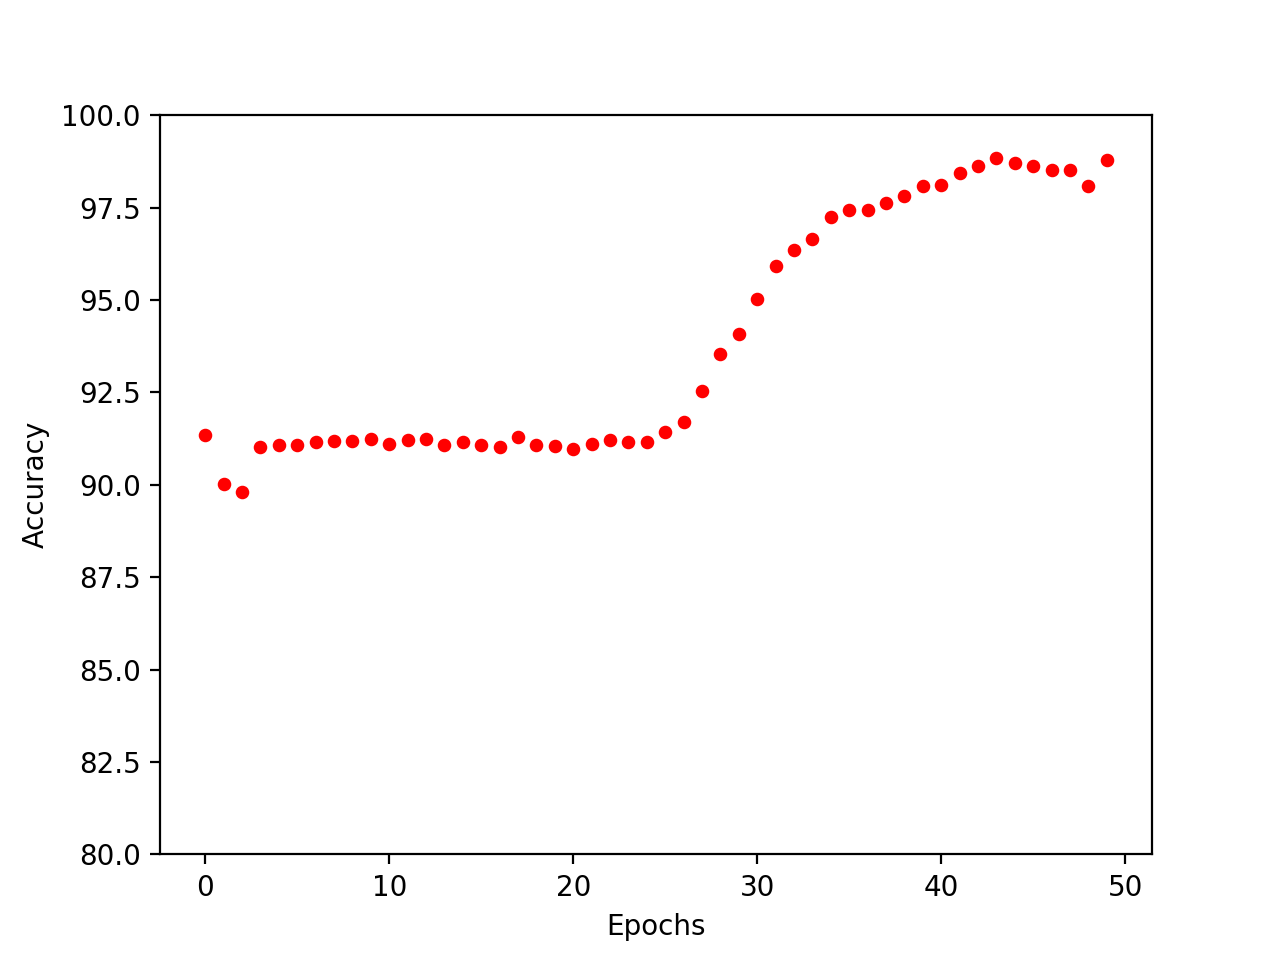

(80, 100)

In [18]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(np.arange(kEpochs), np.array(acc)*100, s=15, color='r')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.ylim(80,100)

In [19]:
# test on qcd background
df = read_file(path_qcd, 1e3)
df['label']=np.zeros(df.shape[0])

In [20]:
batch_size = int(0.5*1024)
dataset = MyDataset(inputs=df, transform='standarize')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [21]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for i_batch, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        #print (outputs)
        #print (labels)
        predicted = torch.round(outputs).view(-1)
        #print (predicted)
        labels = labels.view(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: {:.2f} %'.format(100 * correct / total))

Accuracy: 90.62 %
